In [1]:
import warnings
import numpy as np
import pandas as pd
import sklearn.model_selection as ml
from scipy.stats import norm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import Lasso
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
warnings.filterwarnings('ignore')


In [14]:
def to_row(arr):
    return arr.reshape(1, -1)

def to_col(arr):
    return arr.reshape(-1, 1)

def x_axis(arr):
    return arr[0, :]

def nb(nb_constr, points_training, points_test, labels_training, labels_test):
    naive_bayes = nb_constr(points_training, labels_training)
    print(f'Accuracy: {np.mean(naive_bayes.predict(points_test) == labels_test)}')
    fpr, tpr, _  = roc_curve(labels_test, [el[1] for el in naive_bayes.prob(points_test)])
    plt.plot(fpr, tpr)
    plt.show()



In [3]:
spam_dataset = pd.read_csv("../datasets/spam.csv")
spam_labels = [val for val in spam_dataset['label'].values]
spam_points = spam_dataset.drop(['label'], axis=1).values

spam_points_training, spam_points_test, spam_labels_training, spam_labels_test = ml.train_test_split(spam_points, spam_labels, train_size=0.8)


In [4]:

class GNB:
    def __init__(self, data, labels):
        self.labels_variants = set(labels)
        self.mean = np.array([np.mean(data[labels == label], axis=0) for label in self.labels_variants])
        self.variance = np.array([np.var(data[labels == label], axis=0) for label in self.labels_variants])
        
    def _label_prob(self, label_index, point):
        pdf = norm(self.mean[label_index], self.variance[label_index]).pdf(point)
        return np.sum(np.log(pdf[~np.isnan(pdf)] + 0.0000001))
        
    def _prob_point(self, point):
        probabilities = np.ones(len(self.labels_variants))
        exp_sum = 0
        for (index, label) in enumerate(self.labels_variants):
            label_prob = self._label_prob(index, point)
            probabilities[index] = label_prob
            exp_sum += np.exp(probabilities[index])
        return np.exp(probabilities) / exp_sum
        
    def prob(self, points):
        return np.array([self._prob_point(point) for point in points])
        
    def predict(self, points):
        return np.argmax(self.prob(points), axis=1)


Accuracy: 0.8805646036916395


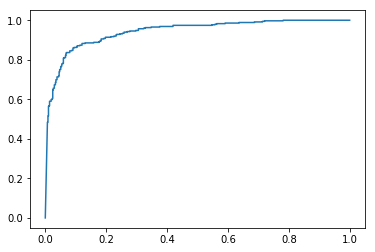

In [15]:
nb(GNB, spam_points_training, spam_points_test, spam_labels_training, spam_labels_test)


In [7]:
sms_spam_dataset = pd.read_csv("../datasets/smsspam.csv")
sms_spam_labels = (sms_spam_dataset["label"].values == 'spam').astype(int)
sms_spam_points = sms_spam_dataset.drop(['label'], axis=1).values.flatten()
sms_spam_points = (CountVectorizer().fit_transform(sms_spam_points) != 0).astype(int)

sms_spam_points_training, sms_spam_points_test, sms_spam_labels_training, sms_spam_labels_test = ml.train_test_split(sms_spam_points, sms_spam_labels, train_size=0.8)


In [8]:
class MNB:
    def __init__(self, data, labels):
        self.labels_variants = set(labels)
        self.bern_prob = np.array([np.asarray(np.mean(data[labels == label], axis=0))[0] for label in self.labels_variants])
        
    def _label_prob(self, label_index, point):
        point_prob = np.multiply(to_row(self.bern_prob[label_index]), point) + np.multiply((1 - to_row(self.bern_prob[label_index])), (1 - point))
        return np.sum(np.log(point_prob + 0.0000001))
        
    def _prob_point(self, point):
        probabilities = np.ones(len(self.labels_variants))
        exp_sum = 0
        for (index, label) in enumerate(self.labels_variants):
            label_prob = self._label_prob(index, point.toarray())
            probabilities[index] = label_prob
            exp_sum += np.exp(probabilities[index])
        return np.exp(probabilities) / exp_sum
        
    def prob(self, points):
        return np.array([self._prob_point(point) for point in points])
        
    def predict(self, points):
        return np.argmax(self.prob(points), axis=1)
    

Accuracy: 0.989237668161435


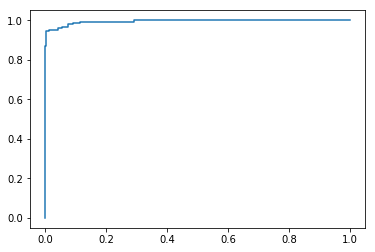

In [16]:
nb(MNB, sms_spam_points_training, sms_spam_points_test, sms_spam_labels_training, sms_spam_labels_test)



In [453]:

noisysine_dataset = pd.read_csv("../datasets/noisysine.csv")
noisysine_labels = [val for val in noisysine_dataset['y'].values]
noisysine_points = noisysine_dataset.drop(['y'], axis=1).values


In [454]:
def r2_score(x, y, weight):
    u = np.sum(np.square((x @ weight).flatten() - y))
    v = np.sum(np.square(np.mean(y) - y))
    return 1 - u / v

def regression(x, y):
    weight = np.linalg.inv(x.T @ x) @ (x.T @ y)
    return to_col(weight)

def pow_regression(points, poly_points, labels, show_plot=True):
    x_train, x_test, y_train, y_test = ml.train_test_split(poly_points, labels, train_size=0.8)
    
    weight = regression(x_train, y_train)
    
    print(f'R^2-score: {r2_score(x_test, y_test, weight)}')

    if show_plot:
        plt.scatter(points, labels)
        plt.plot(points, poly_points @ weight)
        plt.show()
    

R^2-score: 0.0944197299917846


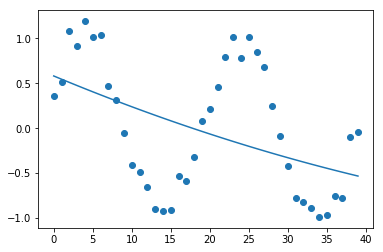

In [460]:
 
pow_regression(noisysine_points, PolynomialFeatures(2).fit_transform(noisysine_points), noisysine_labels)


R^2-score: 0.27714380177859566


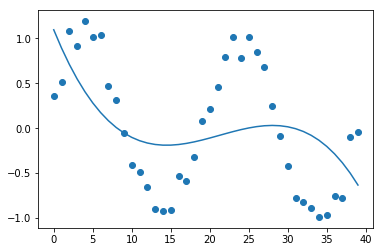

In [462]:
pow_regression(noisysine_points, PolynomialFeatures(3).fit_transform(noisysine_points), noisysine_labels)


R^2-score: 0.3492461788681034


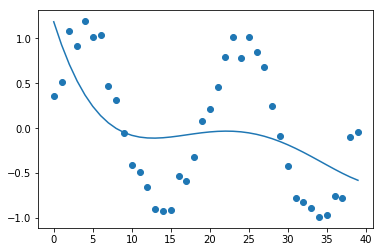

In [467]:
pow_regression(noisysine_points, PolynomialFeatures(4).fit_transform(noisysine_points), noisysine_labels)


R^2-score: 0.8642205525106311


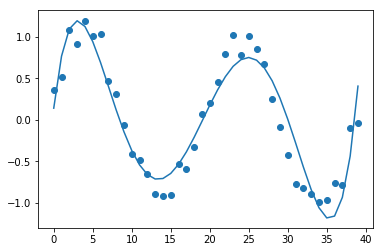

In [470]:
pow_regression(noisysine_points, PolynomialFeatures(5).fit_transform(noisysine_points), noisysine_labels)



In [471]:
hydro_dataset = pd.read_csv("../datasets/hydrodynamics.csv")
hydro_labels = [val for val in hydro_dataset['y'].values]
hydro_points = hydro_dataset.drop(['y'], axis=1).values


In [474]:
pow_regression(hydro_points, PolynomialFeatures(2).fit_transform(hydro_points), hydro_labels, False)


R^2-score: 0.9000464617686452


In [475]:
def ridge_regression(x, y, alpha):
    weight = np.linalg.inv((x.T @ x) + alpha) @ (x.T @ y)
    return to_col(weight)

def search_best_alpha(poly_points, labels):
    x_train, x_test, y_train, y_test = ml.train_test_split(poly_points, labels, train_size=0.8)
    best_r2 = r2_score(x_test, y_test, regression(x_test, y_test))
    
    best_alpha = 0.0
    for cur_pow in range(-10, 10):
        cur_alpha = 10 ** cur_pow
        cur_r2 = r2_score(x_test, y_test, ridge_regression(x_test, y_test, cur_alpha))
        if cur_r2 > best_r2:
            best_r2 = cur_r2
            best_alpha = cur_alpha
    
    return best_alpha


In [476]:
def pow_ridge_regression(points, poly_points, labels, alpha, show_plot=True):
    x_train, x_test, y_train, y_test = ml.train_test_split(poly_points, labels, train_size=0.8)
    
    weight = ridge_regression(x_train, y_train, alpha)
    
    print(f'R^2-score: {r2_score(x_test, y_test, weight)}')

    if show_plot:
        plt.scatter(points, labels)
        plt.plot(points, poly_points @ weight)
        plt.show()
    


Best alpha 2: 1e-09
R^2-score: 0.018890741604932093


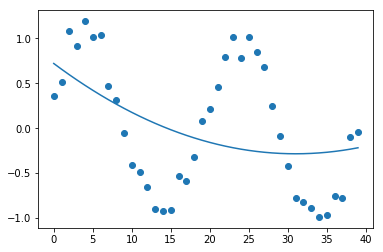

In [485]:
syn_alpha_best_2 = search_best_alpha(PolynomialFeatures(2).fit_transform(noisysine_points), noisysine_labels)
print(f'Best alpha 2: {syn_alpha_best_2}')
pow_ridge_regression(noisysine_points, PolynomialFeatures(2).fit_transform(noisysine_points), noisysine_labels, syn_alpha_best_2)


Best alpha 3: 0.0
R^2-score: 0.1439801293824866


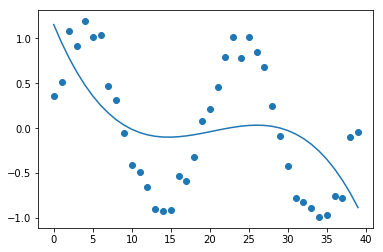

In [496]:
syn_alpha_best_3 = search_best_alpha(PolynomialFeatures(3).fit_transform(noisysine_points), noisysine_labels)
print(f'Best alpha 3: {syn_alpha_best_3}')
pow_ridge_regression(noisysine_points, PolynomialFeatures(3).fit_transform(noisysine_points), noisysine_labels, syn_alpha_best_3)


Best alpha 4: 0.0
R^2-score: 0.23663320925622455


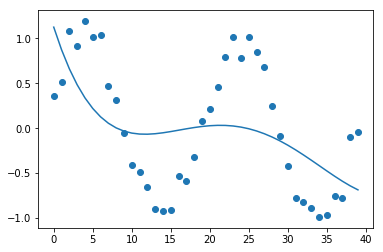

In [497]:
syn_alpha_best_4 = search_best_alpha(PolynomialFeatures(4).fit_transform(noisysine_points), noisysine_labels)
print(f'Best alpha 4: {syn_alpha_best_4}')
pow_ridge_regression(noisysine_points, PolynomialFeatures(4).fit_transform(noisysine_points), noisysine_labels, syn_alpha_best_4)


Best alpha 5: 1e-10
R^2-score: 0.9087392084221613


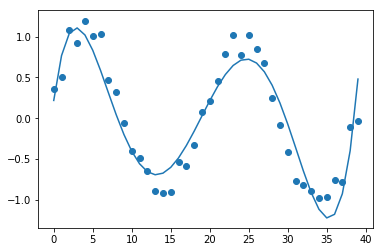

In [507]:
syn_alpha_best_5 = search_best_alpha(PolynomialFeatures(5).fit_transform(noisysine_points), noisysine_labels)
print(f'Best alpha 5: {syn_alpha_best_5}')
pow_ridge_regression(noisysine_points, PolynomialFeatures(5).fit_transform(noisysine_points), noisysine_labels, syn_alpha_best_5)


In [509]:
hydro_alpha_best_2 = search_best_alpha(PolynomialFeatures(2).fit_transform(hydro_points), hydro_labels)
print(f'Best alpha 2: {hydro_alpha_best_2}')
pow_ridge_regression(hydro_points, PolynomialFeatures(2).fit_transform(hydro_points), hydro_labels, hydro_alpha_best_2, show_plot=False)



Best alpha 2: 1e-10
R^2-score: 0.9266117036081448


In [510]:
def lasso(points, poly_points, labels, show_plot=True):
    x_train, x_test, y_train, y_test = ml.train_test_split(poly_points, labels, train_size=0.8)
    
    best_alpha = 0.0

    las = Lasso(alpha=best_alpha)
    las.fit(x_train, y_train)
    
    best_score = las.score(x_test, y_test)
    
    
    for cur_pow in range(-10, 10):
        cur_alpha = 10 ** cur_pow
        
        las = Lasso(alpha=cur_alpha)
        las.fit(x_train, y_train)

        cur_score = las.score(x_test, y_test)
        if cur_score > best_score:
            best_score = cur_score
            best_alpha = cur_alpha
            
    las = Lasso(alpha=best_alpha)
    las.fit(x_train, y_train)
    
    print(f'Lasso score: {las.score(x_test, y_test)}. Num: {len(list(filter(lambda x : x != 0, las.coef_)))}')

    if show_plot:
        plt.scatter(points, labels)
        plt.plot(points, las.predict(poly_points))
        plt.show()
        

Lasso score: 0.029133287438327327. Num: 1


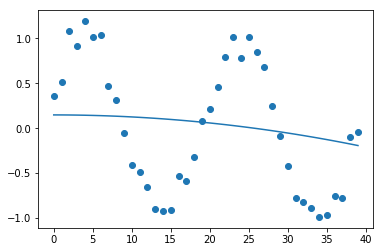

In [513]:
lasso(noisysine_points, PolynomialFeatures(2).fit_transform(noisysine_points), noisysine_labels)


Lasso score: 0.3176079877409803. Num: 3


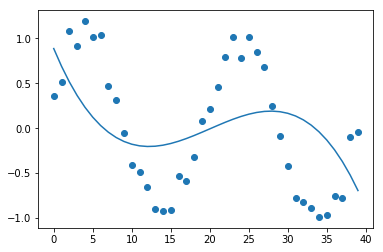

In [515]:
lasso(noisysine_points, PolynomialFeatures(3).fit_transform(noisysine_points), noisysine_labels)


Lasso score: 0.4195520776226948. Num: 4


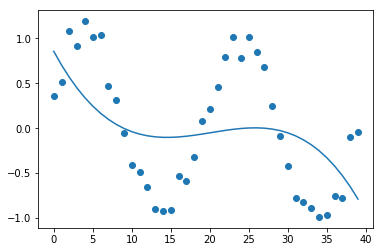

In [523]:
lasso(noisysine_points, PolynomialFeatures(4).fit_transform(noisysine_points), noisysine_labels)


Lasso score: 0.41044522475796485. Num: 5


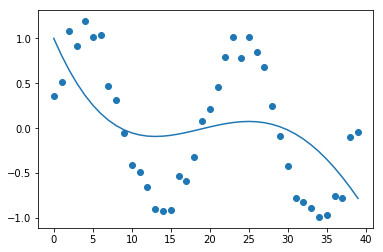

In [578]:
lasso(noisysine_points, PolynomialFeatures(5).fit_transform(noisysine_points), noisysine_labels)



In [579]:
lasso(hydro_points, PolynomialFeatures(2).fit_transform(hydro_points), hydro_labels, False)


Lasso score: 0.9127034016953691. Num: 22
